### Pennylane implementation of the QEMC algorithm (Ref. https://arxiv.org/abs/2308.10383)
Wrong version of the QEMC algorithm. The correct version is in the file QEMC_implementationV2.ipynb

In [19]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# Matplolib style
plt.style.use('https://github.com/kaiuki2000/PitayaRemix/raw/main/PitayaRemix.mplstyle')

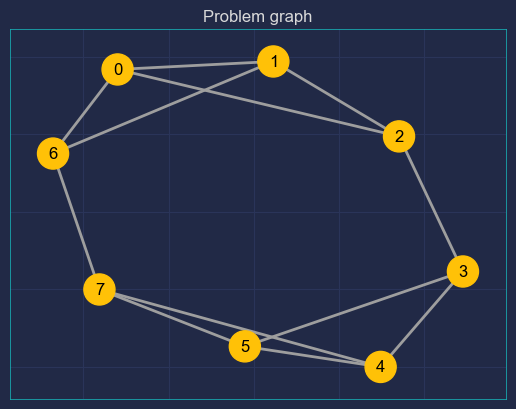

In [20]:
# set the random seed
np.random.seed(42)

# number of qubits in the circuit
n_nodes = 8
# graph edges as a list of tuples
graph = [(0, 1), (0, 2), (0, 6), (1, 2), (1, 6), \
         (3, 2), (3, 5), (4, 3), (4, 5), (4, 7), \
         (5, 7), (1, 2), (6, 7)]
graph_nx = nx.Graph(graph)

# set node colors and size
node_colors = ["#FFC107" for node in graph_nx.nodes()]
node_size = 500

# set edge colors and width
edge_colors = ["#9E9E9E" for edge in graph_nx.edges()]
edge_width = 2

# set layout
pos = nx.spring_layout(graph_nx)

# draw graph
nx.draw_networkx(graph_nx, pos=pos, with_labels=True, node_color=node_colors, node_size=node_size, edge_color=edge_colors, width=edge_width)
plt.title("Problem graph")
plt.show()

We can also use the "Strongly Entangled Layers" function from Pennylane, but I'll try doing things from scratch first.

In [21]:
# params is something like this
params = [
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ],
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
]

# Random initialization of parameters
n_layers = 2
params = 0.01 * np.random.rand(n_layers, 3, 3, requires_grad=True)

# QEMC layer definition
def qemc_layer(params, **kwargs):
    global c;
    n_wires = kwargs.pop('n_wires') # default value not specified: raises KeyError if n_wires is not specified
    rs = kwargs.pop('rs') # range: hyperparameter
    for i in range(n_wires):
        qml.RX(params[i][0], wires = i)
        qml.RY(params[i][1], wires = i)
        qml.RZ(params[i][2], wires = i)
    for j in range(n_wires):
        qml.CNOT(wires = [j, (j+rs[c]) % n_wires])
    c += 1

In [22]:
n_wires = 3; rs = [1, 2]
dev = qml.device("lightning.qubit", wires = n_wires, shots=1)

c = 0;
@qml.qnode(dev)
def circuit(params):
    global c; c = 0
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    qml.layer(qemc_layer, len(rs), params, rs = rs, n_wires = n_wires)
    return qml.sample()

print(f'Quantum circuit drawing:\n{qml.draw(circuit)(params)}')

Quantum circuit drawing:
0: ──H──RX(0.00)──RY(0.01)──RZ(0.00)─╭●────╭X──RX(0.01)──RY(0.00)──RZ(0.01)─╭●─╭X────┤  Sample
1: ──H──RX(0.00)──RY(0.01)──RZ(0.00)─╰X─╭●─│───RX(0.01)──RY(0.00)──RZ(0.01)─│──╰●─╭X─┤  Sample
2: ──H──RX(0.00)──RY(0.00)──RZ(0.00)────╰X─╰●──RX(0.00)──RY(0.00)──RZ(0.01)─╰X────╰●─┤  Sample


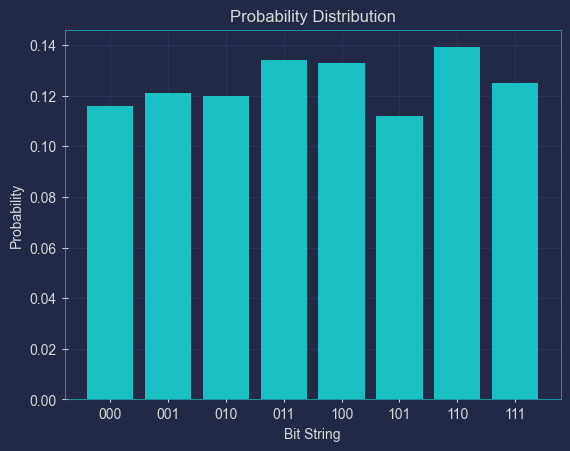

In [23]:
# test block
# convert a bitstring sample to the corresponding integer
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

bit_strings = []
n_samples = 1000
for i in range(0, n_samples):
    bit_strings.append(bitstring_to_int(circuit(params)))

# plot the probability distribution
def plot_prob_dist(bit_strings):
    # count the occurrences of each bit string
    counts = np.bincount(bit_strings)

    # calculate the probabilities
    probabilities = counts / len(bit_strings)

    # generate x-axis labels for each bit string
    x_labels = [format(i, '03b') for i in range(len(counts))]

    # plot the histogram
    plt.bar(x_labels, probabilities)
    plt.xlabel('Bit String')
    plt.ylabel('Probability')
    plt.title('Probability Distribution')
    plt.show()
plot_prob_dist(bit_strings)

In [24]:
def qemc_maxcut(N, n_layers, edges):
    B = N/2; # definition of B
    # quick note: N is the number of nodes in the graph
    print("QEMC level: p={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(n_layers, 3, 3, requires_grad=True)

    # minimize the objective function
    def objective(params):
        n_samples = 3*N**2; bit_strings = []
        for i in range(0, n_samples):
            bit_strings.append(bitstring_to_int(circuit(params)))

        # count the occurrences of each bit string
        counts = np.bincount(bit_strings)
        # calculate the probabilities
        probs = counts / len(bit_strings)

        cost = 0
        for edge in edges:
            # j and k are the nodes connected by the edge
            # 0: j, 1: k
            d_jk = np.abs(probs[edge[0]] - probs[edge[1]]); s_jk = probs[edge[0]] + probs[edge[1]]
            edge_cost = (d_jk - 1/B)**2 + (s_jk - 1/B)**2
            cost += edge_cost
        return cost

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdamOptimizer(stepsize = 0.99)

    # optimize parameters in objective
    params = init_params
    iterations = 300
    for i in range(iterations):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, objective(params)))

    # sample measured bitstrings 3*N**2 times
    bit_strings = []
    n_samples = 3*N**2
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (params) vectors:\n{}".format(params))
    print("Most frequently sampled bit string is: {:03b}".format(most_freq_bit_string))
    print(f"Circuit drawing, n_layers={n_layers}:")
    print( qml.draw(circuit)(params) )

    return objective(params), bit_strings

In [25]:
N = 8 # number of nodes
n_layers = 2 # number of layers
qemc_maxcut(N, n_layers, graph)

QEMC level: p=2


TypeError: Can't differentiate w.r.t. type <class 'numpy.int32'>

Okay, so I'm keeping this notebook here for future reference, in case I make the same mistakes later on in my work. The reason why this doesn't work is because I am sampling the quantum circuit. As a result, we obtain a list of *bitstrings*, that are essentially `ints`. This confuses the optimization algorithm (in this case `Adam`), which is expecting `floats` only. Even though these `ints` are not necessarily parameters of our `objective` function, it still doesn't work! So, keep this in mind! The workaround was to not sample the quantum circuit. Instead, we use the analytical results (**probability distribution!**), obtained directly from the state-vector. This being a list of `floats`, can now be used by the optimizer. I guess that's exactly the advantage of these **classical noiseless state-vector** simulations - we do not need to sample.

TLDR: The objective function cannot have anything to do with `ints`! It has to be `floats` only!